In [13]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import*

In [14]:
I2 = np.matrix([[1,0],[0,1]])
H  = np.matrix([[1,1],[1,-1]])* (1/np.sqrt(2))
S  = np.matrix([[1,0],[0,1j]])
X  = np.matrix([[0,1],[1,0]])
Y  = np.matrix([[0,-1j],[1j,0]])
Z  = np.matrix([[1,0],[0,-1]])

In [15]:
r"""
# parameters of Hamiltonians and Lindbladians
b       = 0.1
gamma_1 = 0.02
gamma_2 = 0.05

I2 = pauli_list[0]
X = pauli_list[1]
Y = pauli_list[2]
Z = pauli_list[3]
Hamiltonian = (-b/2)*X
L_1 = np.sqrt(gamma_1)*np.matrix([[0,1],[1,0]])
L_2 = np.sqrt(gamma_2)*Z

# steady state density matrix parameters
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss   = (2*b*gamma_1)/Delta
zss   = (gamma_1*(gamma_1+4*gamma_2))/Delta

# steady state density matrix
rho_ss = (1/2)*(I2+yss*Y+zss*Z)

# angles for steady state preparation
theta_x = np.arccos(zss)
theta_y = np.arccos(-yss/(4*np.sqrt(1+zss**2)))""";

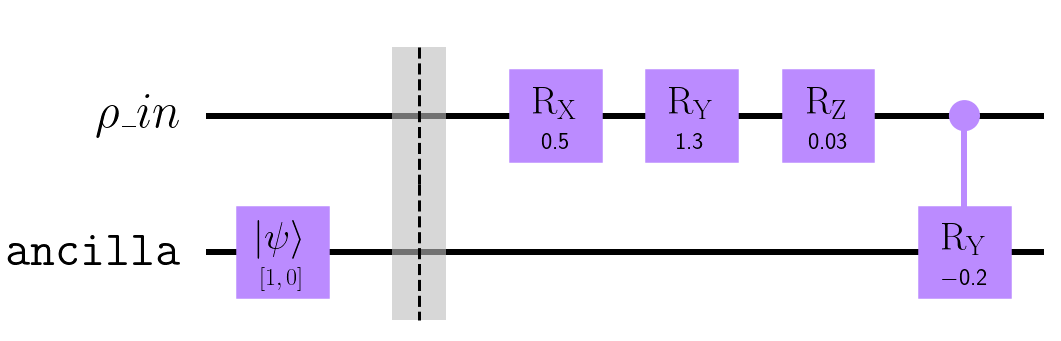

In [16]:
# number of qubits in the system
N_qubit = 2

# parameters of the circuit.
theta_x = 0.5
theta_y = 1.3
theta_z = 0.03
theta_ry = -0.2

# setting up the quantum circuit
density_matrix_qubit = QuantumRegister(1, r"\rho_{in}")
ancilla_qubit = QuantumRegister(1, r"\texttt{ancilla}")
qc = QuantumCircuit(density_matrix_qubit,ancilla_qubit)
# initializing the ancilla qubit at |0>.
qc.initialize([1,0],1)
qc.barrier()
qc.rx(theta_x,0)
qc.ry(theta_y,0)
qc.rz(theta_z,0)
qc.cry(theta_ry,0,1)

# returns N*K classical shadows.
def classical_shadow_using_ST(N,K):
    # number of shadows
    nShadows = N*K
    # number of shots
    number_of_shots = 1
    rng = np.random.default_rng(1729)
    cliffords = [qiskit.quantum_info.random_clifford(N_qubit, seed=rng) for _ in range(nShadows)]    
    results = []    
    for cliff in cliffords:
        qc_c  = qc.compose(cliff.to_circuit())
        # samples the output in computational basis.
        counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(number_of_shots)
        results.append(counts)
        
    # performing rho_hat = (2**N+1)*(U^{\dagger}|b><b|U-I).
    shadow_lst = []
    # loops over the clifford gates and their corresponding measurement results.
    for cliff, res in zip(cliffords, results):
        # U^{\dagger} matrix.
        mat    = cliff.adjoint().to_matrix()
        for bit,count in res.items():
            Ub = mat[:,int(bit,2)] # this is Udag|b>
            shadow_lst.append(((2**N_qubit+1.))*np.outer(Ub,Ub.conj())*count - np.eye(2**N_qubit))    
    return shadow_lst

qc.draw("mpl", scale=3,style="clifford")

In [17]:
M = 1
2*np.log(2*M/0.01)

10.596634733096073

In [18]:
N = 50
K = 10
set_of_shadows = classical_shadow_using_ST(N,K)
# average classical shadow.
rho_shadow = np.sum(set_of_shadows,axis=0)/(len(set_of_shadows))
# exact density matrix.
rho_exact = qiskit.quantum_info.DensityMatrix(qc).data

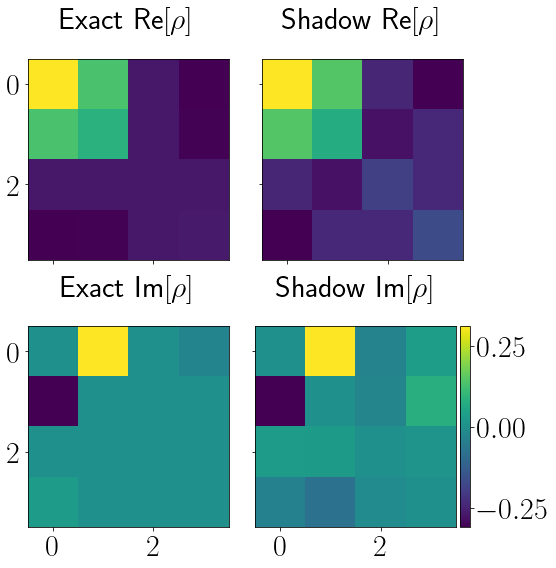

In [19]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)

c1 = axs[0, 0].imshow(rho_exact.real)
axs[0, 0].set_title(r"Exact Re$[\rho]$")

c2 = axs[0, 1].imshow(rho_shadow.real)
axs[0, 1].set_title(r"Shadow Re$[\rho]$")

c3 = axs[1, 0].imshow(rho_exact.imag)
axs[1, 0].set_title(r"Exact Im$[\rho]$")

c4 = axs[1, 1].imshow(rho_shadow.imag)
axs[1, 1].set_title(r"Shadow Im$[\rho]$")

#plt.suptitle("N = "+str(len(set_of_shadows)))

#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(c4, cax=cax, orientation='vertical')

# Display the figure with subplots
plt.tight_layout()    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
#plt.savefig("density_matrix_comparison_"+str(len(set_of_shadows))+".jpg", dpi=600)
plt.show()

In [20]:
def quadratic_o_i_k(N,k,Operator_1, Operator_2):
    s = 0.0
    for j in range(N*(k-1)+1,N*k+1):
        for l in range(N*(k-1)+1,N*k+1):
            if j != l:
                rho_j = set_of_shadows[j]
                rho_l = set_of_shadows[l]
                s += np.trace(np.kron(Operator_1,I2)@rho_j@np.kron(Operator_2,I2)@rho_l)
    return (1/(N*(N-1)))*s
def linear_o_i_k(N,k,Operator):
    s = 0.0
    for j in range(N*(k-1)+1,N*k+1):
        rho_j = set_of_shadows[j]
        s += np.trace(Operator@rho_j)
    return s/N

In [21]:
o_linear = np.median([linear_o_i_k(N,kk,np.kron(X,I2)) for kk in range(K)])
print(o_linear)

(-0.09999999999999998+0j)


In [22]:
np.trace(np.kron(X,I2)@rho_exact)

(-0.07601562349790089+0j)

In [23]:
#o_quadratic = np.median([quadratic_o_i_k(N,kk,X,Z) for kk in range(K)])
#print(o_quadratic)

In [24]:
#np.trace(np.kron(X,Z)@rho_exact)